In [1]:
import random
import os
#import cv2
import glob
import sys
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import math

noise_path = "./Not_face/"
thermal_path = "./Thermal_only/"
augment_path = "./Noise_face/"
mixed_path = "./Noise&Face/"
CSV_path =  "./Noise&Face_CSV/"

warnings.filterwarnings("ignore")

In [2]:
#Set a seed for RNG
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    
set_seed(42)

In [3]:
#Calculate the average value or standard deviation of an image (np array in this case)
#Parameters:
    #img: np array of an image
    #thresh: value threshold for filtering unwanted elements (i.e thresh = 30, values under 30 become nan)
#Outputs:
    #mean/std: the mean value of an image
    
def get_avgval(img, thresh):
    img = img.astype(np.float32)
    img[img <= thresh] = np.nan #converts values below threshold into nan for filtering
    mean = np.nanmean(img) #remove nan values and calculate mean
    return mean

def get_std(img, thresh):
    img = img.astype(np.float32)
    img[img <= thresh] = np.nan #converts values below threshold into nan for filtering
    std = np.nanstd(img) #remove nan values and calculate mean
    return std
    

In [4]:
# Noise generating functions:
# Source: https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv

    # Parameters
    # ----------
    # image : ndarray
    #     Input image data. Will be converted to float.
    # mode : str
    #     One of the following strings, selecting the type of noise to add:

    #     'gauss'     Gaussian-distributed additive noise.
    #     'poisson'   Poisson-distributed noise generated from the data.
    #     's&p'       Replaces random pixels with 0 or 1.
    #     'speckle'   Multiplicative noise using out = image + n*image,where
    #                 n is uniform noise with specified mean & variance.

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = get_avgval(image,35)
        var = get_std(image,35)**2
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        out[coords] = 255

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
#         vals = len(np.unique(image))
#         vals = 2 ** np.ceil(np.log2(vals))
#         noisy = np.random.poisson(image * vals) / float(vals)
        PEAK = 3
        noisy = np.random.poisson(image / 255.0 * PEAK) / PEAK * 255 
        noisy = noisy + image
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

(350, 465, 1)


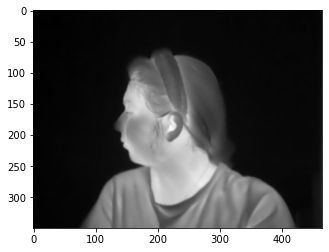

In [5]:
#read and plot sample image
#sample_img = cv2.imread(thermal_path+"N11102.jpg")
sample = np.asarray(Image.open(thermal_path+"N11102.jpg"))
sample = np.expand_dims(sample, axis=2)
print(sample.shape)
imgplot = plt.imshow(sample, cmap="gray")


In [6]:
#np.set_printoptions(threshold=sys.maxsize)
#print(sample) #useful for figuring out value exclusion range...

In [7]:
#Calc mean of the sample image, view other statistics
mean = get_avgval(sample, 35)
std = get_std(sample, 35)

smax = np.amax(sample)
smin = np.amin(sample)
print("mean: ", mean)
print("std: ", std)
print("max: ", smax)
print("min: ", smin)

mean = int(mean)
print("rounded mean: ", mean)

mean:  130.43062
std:  46.381645
max:  255
min:  0
rounded mean:  130


(350, 465, 1)


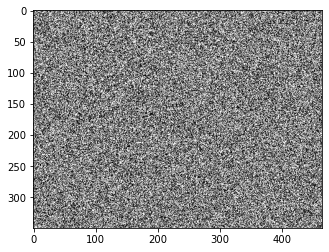

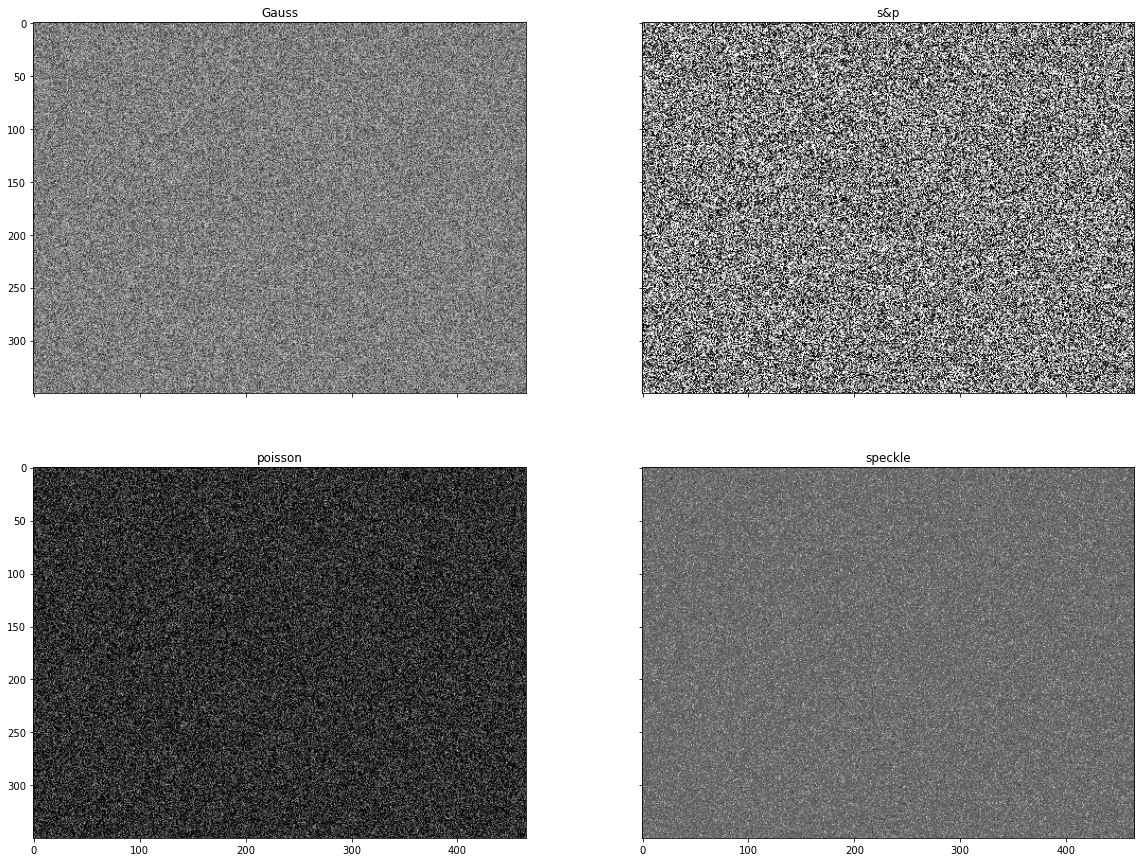

In [8]:
#create sample noise image
height, width, channel = sample.shape
nsample = np.asarray(Image.effect_noise((width,height), mean))
nsample = np.expand_dims(nsample, axis=2)
print(nsample.shape)
imgplot = plt.imshow(nsample, cmap="gray")

gauss_sample = noisy("gauss",nsample)
sandp_sample = noisy("s&p",nsample)
poisson_sample = noisy("poisson",nsample)
speckle_sample = noisy("speckle",nsample)

fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0, 0].imshow(gauss_sample, cmap="gray")
axs[0, 0].set_title('Gauss')

axs[0, 1].imshow(sandp_sample, cmap="gray")
axs[0, 1].set_title('s&p')

axs[1, 0].imshow(poisson_sample, cmap="gray")
axs[1, 0].set_title('poisson')

axs[1, 1].imshow(speckle_sample, cmap="gray")
axs[1, 1].set_title('speckle')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

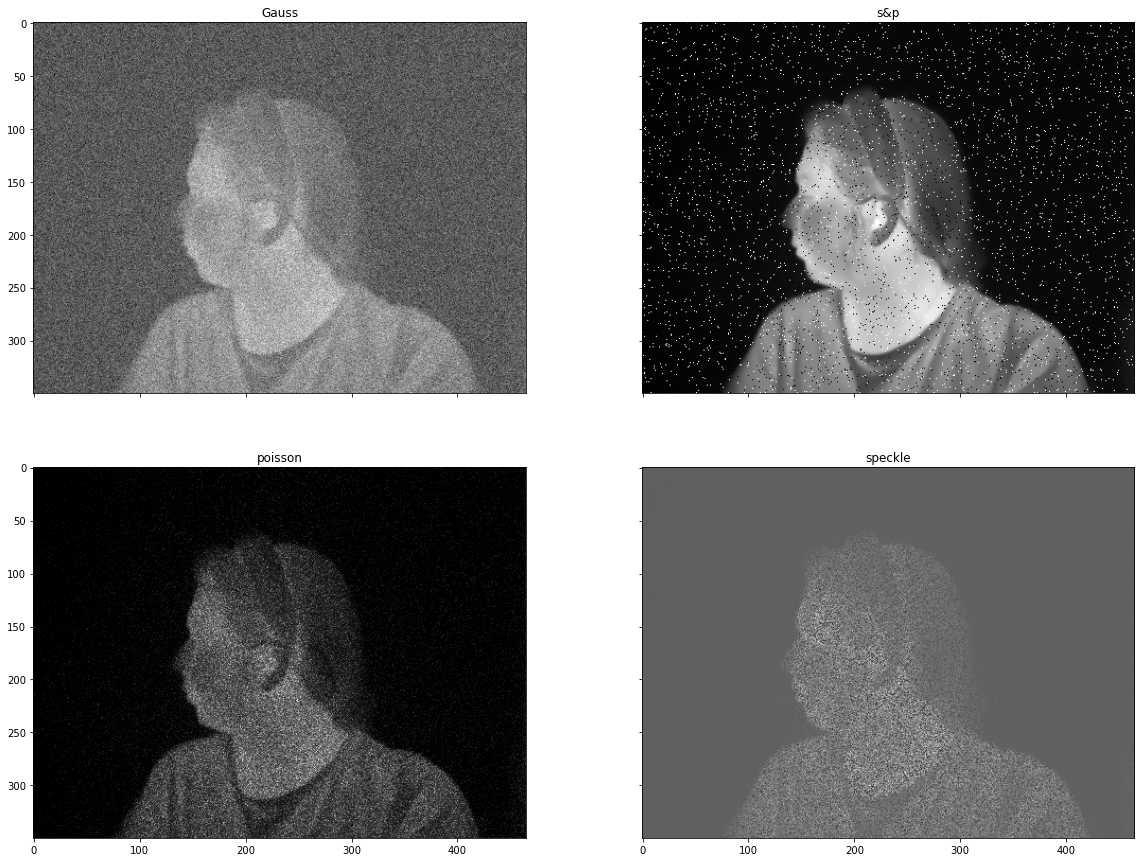

In [9]:
gauss_sample = noisy("gauss",sample)
sandp_sample = noisy("s&p",sample)
poisson_sample = noisy("poisson",sample)
speckle_sample = noisy("speckle",sample)

fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0, 0].imshow(gauss_sample, cmap="gray")
axs[0, 0].set_title('Gauss')

axs[0, 1].imshow(sandp_sample, cmap="gray")
axs[0, 1].set_title('s&p')

axs[1, 0].imshow(poisson_sample, cmap="gray")
axs[1, 0].set_title('poisson')

axs[1, 1].imshow(speckle_sample, cmap="gray")
axs[1, 1].set_title('speckle')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

(55, 65, 1)
mean:  171.3102
std:  58.984344
max:  255
min:  0
rounded mean:  171


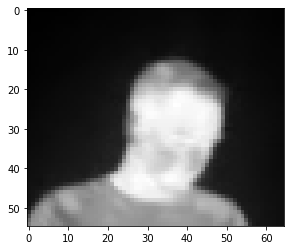

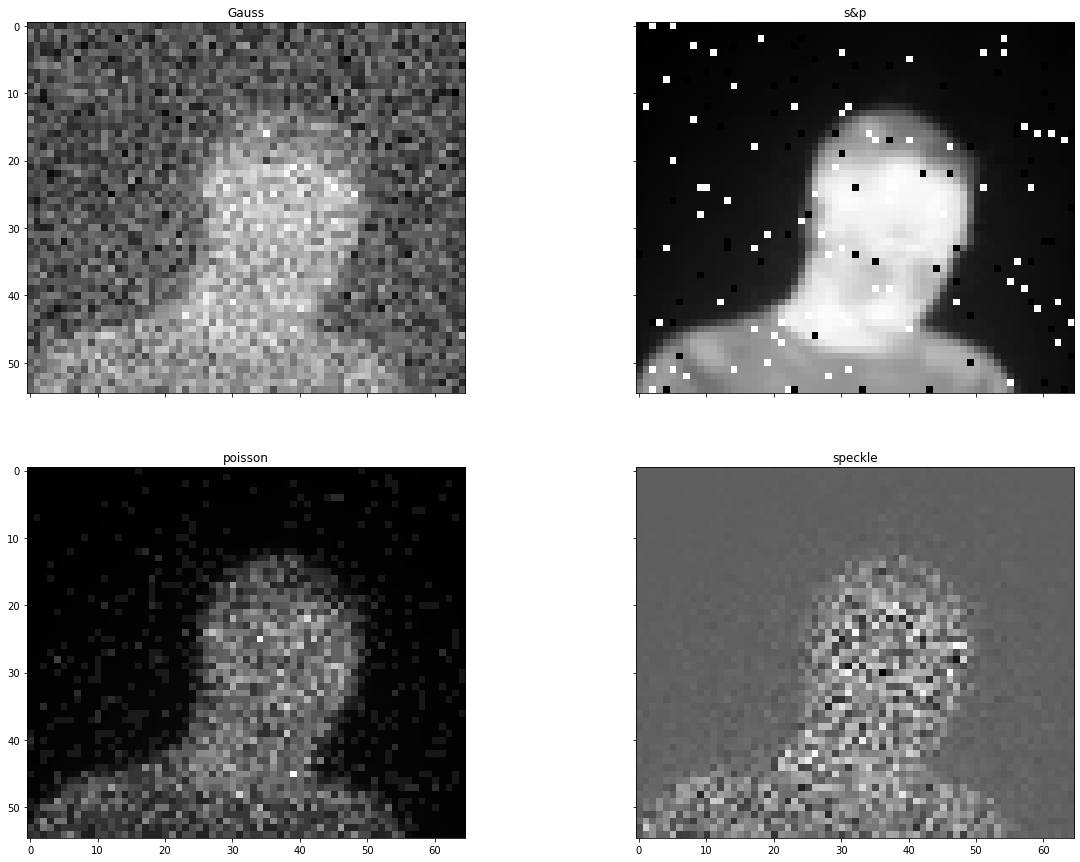

In [10]:
#Try another (low-res) sample image
#read and plot sample image
#sample_img = cv2.imread(thermal_path+"N11102.jpg")
sample = np.asarray(Image.open(thermal_path+"N716617.jpg"))
sample = np.expand_dims(sample, axis=2)
print(sample.shape)
imgplot = plt.imshow(sample,cmap="gray")
 #Calc mean of the sample image, view other statistics
mean = get_avgval(sample, 35)
std = get_std(sample, 35)

smax = np.amax(sample)
smin = np.amin(sample)
print("mean: ", mean)
print("std: ", std)
print("max: ", smax)
print("min: ", smin)

mean = int(mean)
print("rounded mean: ", mean)

gauss_sample = noisy("gauss",sample)
sandp_sample = noisy("s&p",sample)
poisson_sample = noisy("poisson",sample)
speckle_sample = noisy("speckle",sample)

fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0, 0].imshow(gauss_sample, cmap="gray")
axs[0, 0].set_title('Gauss')

axs[0, 1].imshow(sandp_sample, cmap="gray")
axs[0, 1].set_title('s&p')

axs[1, 0].imshow(poisson_sample, cmap="gray")
axs[1, 0].set_title('poisson')

axs[1, 1].imshow(speckle_sample, cmap="gray")
axs[1, 1].set_title('speckle')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [11]:
def ink(w, h, b):
    bs = w*h
    imgsize = (w, h)
    color = (255)
    img = Image.new("L", imgsize, "black")

    for j in range(0,b):
        start = (random.randrange(0, math.floor(imgsize[0]/2)), random.randrange(0, imgsize[1]))
        point = start
        color = random.randrange(5, 255)
        img.putpixel(point, color)

        blotsize = random.randrange(0, bs)
        for i in range(blotsize):
            
            directions = [(point[0], point[1]+1), (point[0], point[1]-1), (point[0]+1, point[1]), (point[0]-1, point[1])]
            toremove = []
            for direction in directions:
                if direction[0]>=(math.floor(imgsize[0]/2)) or direction[1]>=imgsize[1] or direction[0]<0 or direction[1]<0:
                    toremove.append(direction)
            for d in toremove:
                directions.remove(d)
            point = random.choice(directions)
            img.putpixel(point, color)

    cropped = img.crop((0, 0, int(math.floor(imgsize[0]/2)), imgsize[1]))
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    img.paste(cropped, (0, 0, int(math.floor(imgsize[0]/2)), int(imgsize[1])))

    sample = np.asarray(img)
#     sample = np.transpose(sample)
    return sample

55 55
(55, 65, 1)


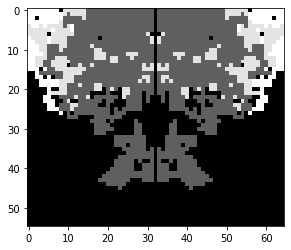

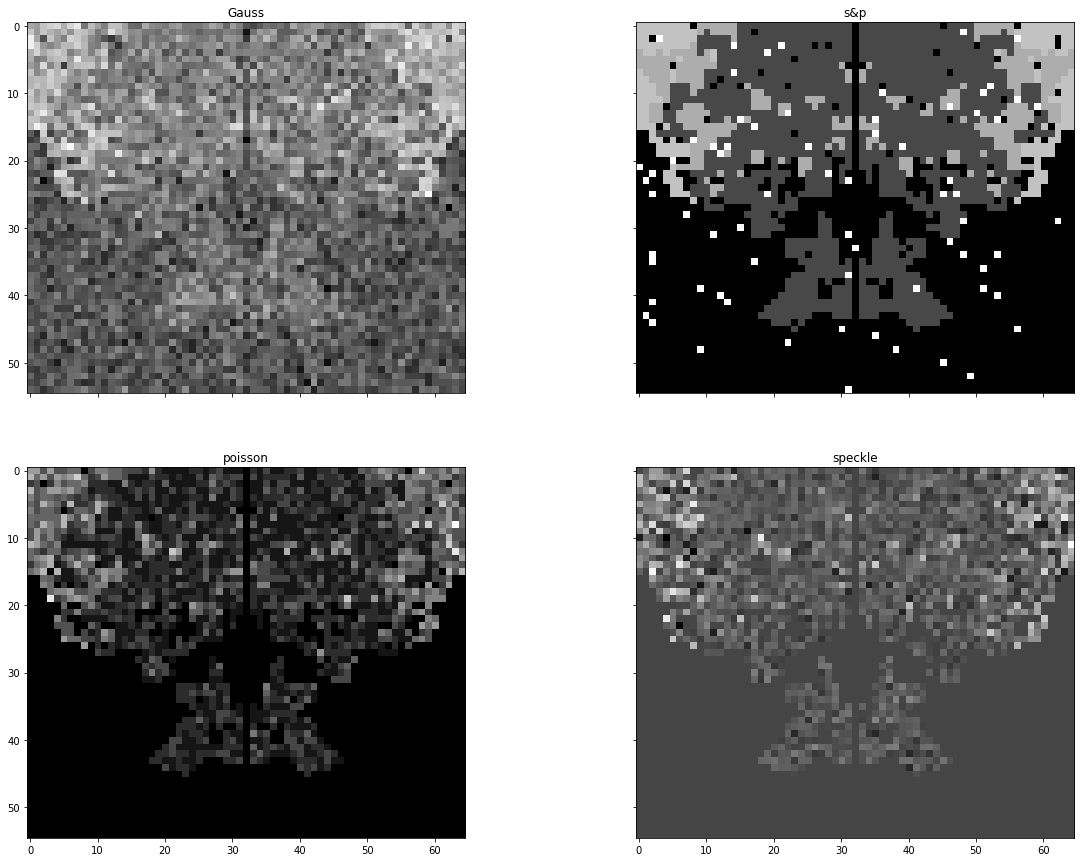

In [12]:
#create sample noise image
height, width, channel = sample.shape

print(55, 55)
nsample = ink(width, height, 4)
nsample = np.expand_dims(nsample, axis=2)
print(nsample.shape)
imgplot = plt.imshow(nsample, cmap="gray")

gauss_sample = noisy("gauss",nsample)
sandp_sample = noisy("s&p",nsample)
poisson_sample = noisy("poisson",nsample)
speckle_sample = noisy("speckle",nsample)

fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0, 0].imshow(gauss_sample, cmap="gray")
axs[0, 0].set_title('Gauss')

axs[0, 1].imshow(sandp_sample, cmap="gray")
axs[0, 1].set_title('s&p')

axs[1, 0].imshow(poisson_sample, cmap="gray")
axs[1, 0].set_title('poisson')

axs[1, 1].imshow(speckle_sample, cmap="gray")
axs[1, 1].set_title('speckle')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [13]:
#Load raw thermal images 
raw_images = [np.asarray(Image.open(file)) for file in tqdm(glob.glob(thermal_path+"*.jpg"))]

  0%|          | 0/10373 [00:00<?, ?it/s]

In [14]:
#Add dimension for channels...
expanded_raw = []
for count, img in enumerate(tqdm(raw_images)):
    img = np.expand_dims(img, axis=2)
    expanded_raw.append(img)

  0%|          | 0/10373 [00:00<?, ?it/s]

In [15]:
#Print example shape of image
print(expanded_raw[1000].shape)
# print(np.squeeze(expanded_raw[1000], axis=2).shape)

(78, 100, 1)


In [16]:
def perform_rand_augment(image, randnum):
    if randnum == 0: #Do not augment image
        aug_image = image
        return aug_image
    
    #Apply different noise techniques
    elif randnum == 1:
        aug_image = noisy("gauss",image)
        return aug_image
        
    elif randnum == 2:
        aug_image = noisy("s&p",image)
        return aug_image
    
    elif randnum == 3:
        aug_image = noisy("poisson",image)
        return aug_image
    
    elif randnum == 4:
        aug_image = noisy("speckle",image)
        return aug_image


In [17]:
print("Total images in dataset: ", len(expanded_raw))
index_vals = random.sample(list(enumerate(expanded_raw)), math.ceil(0.1*len(expanded_raw)))
indexes = []
test_list = []
for idx, val in index_vals:
    indexes.append(idx)
    test_list.append(val)
print("Numbers of images in test set: ",len(test_list))

train_list = [element for i, element in enumerate(expanded_raw) if i not in indexes]

# indexes = []
# val_list = []
# index_vals = random.sample(list(enumerate(train_list)), math.ceil(0.2*len(train_list)))
# for idx, val in index_vals:
#     indexes.append(idx)
#     val_list.append(val)
# print("Numbers of images in validation set: ",len(val_list))

# train_list = [element for i, element in enumerate(train_list) if i not in indexes]
print("Numbers of images in training set: ",len(train_list))


#print(len(train_list)+len(test_list)+len(val_list))

Total images in dataset:  10373
Numbers of images in test set:  1038
Numbers of images in training set:  9335


In [18]:
# # data = []
# is_face = 1
# not_face = 0
# for count, img in enumerate(tqdm(expanded_raw)):
#     augnum = random.randint(0, 3)
#     img = perform_rand_augment(img,augnum)
#     img = np.squeeze(img, axis=2)
#     result = Image.fromarray((img).astype(np.uint8))
#     result.save(augment_path+"face%d.jpg" % count)
#     result.save(mixed_path+"face%d.jpg" % count)
# #     data.append({"File":(mixed_path+"face%d.jpg" % count),
# #                  "Class": is_face
# #                 })
    
#     height, width = img.shape
#     nimg = np.asarray(Image.effect_noise((width,height), mean))
#     nimg = np.expand_dims(nimg, axis=2)
#     nimg = np.squeeze(nimg, axis=2)
#     nresult = Image.fromarray((nimg).astype(np.uint8))
#     nresult.save(noise_path+"not_face%d.jpg" % count)
#     nresult.save(mixed_path+"not_face%d.jpg" % count)
# #     data.append({"File":(mixed_path+"not_face%d.jpg" % count),
# #                  "Class": not_face
# #                 })
    
# # df = pd.DataFrame(data)
# # df

In [19]:
#Training
data = []
is_face = 1
not_face = 0
for count, img in enumerate(tqdm(train_list)):
    augnum = random.randint(0, 4)
    img = perform_rand_augment(img,augnum)
    img = np.squeeze(img, axis=2)
    result = Image.fromarray((img).astype(np.uint8))
    result.save(mixed_path+"train/is_face/face%d.jpg" % count)
    data.append({"File":(mixed_path+"train/is_face/face%d.jpg" % count),
                 "Class": is_face
                })
    
    height, width = img.shape
#     nimg = np.asarray(Image.effect_noise((width,height), mean))
    nimg = ink(width, height, random.randint(2, 5))
    nimg = np.expand_dims(nimg, axis=2)
    nimg = perform_rand_augment(nimg,augnum)
    nimg = np.squeeze(nimg, axis=2)
    nresult = Image.fromarray((nimg).astype(np.uint8))
    nresult.save(mixed_path+"train/not_face/not_face%d.jpg" % count)
    data.append({"File":(mixed_path+"train/not_face/not_face%d.jpg" % count),
                 "Class": not_face
                })
    
df = pd.DataFrame(data)
df

  0%|          | 0/9335 [00:00<?, ?it/s]

,File,Class
0,./Noise&Face/train/is_face/face0.jpg,1
1,./Noise&Face/train/not_face/not_face0.jpg,0
2,./Noise&Face/train/is_face/face1.jpg,1
3,./Noise&Face/train/not_face/not_face1.jpg,0
4,./Noise&Face/train/is_face/face2.jpg,1
...,...,...
18665,./Noise&Face/train/not_face/not_face9332.jpg,0
18666,./Noise&Face/train/is_face/face9333.jpg,1
18667,./Noise&Face/train/not_face/not_face9333.jpg,0
18668,./Noise&Face/train/is_face/face9334.jpg,1


In [20]:
#Validate
# is_face = 1
# not_face = 0
# for count, img in enumerate(tqdm(val_list)):
#     augnum = random.randint(0, 3)
#     img = perform_rand_augment(img,augnum)
#     img = np.squeeze(img, axis=2)
#     result = Image.fromarray((img).astype(np.uint8))
#     result.save(mixed_path+"valid/is_face/face%d.jpg" % count)
# #     result.save(mixed_path+"face%d.jpg" % count)
# #     data.append({"File":(mixed_path+"face%d.jpg" % count),
# #                  "Class": is_face
# #                 })
    
#     height, width = img.shape
#     nimg = np.asarray(Image.effect_noise((width,height), mean))
#     nimg = np.expand_dims(nimg, axis=2)
#     nimg = np.squeeze(nimg, axis=2)
#     nresult = Image.fromarray((nimg).astype(np.uint8))
#     nresult.save(mixed_path+"valid/not_face/not_face%d.jpg" % count)
# #     nresult.save(mixed_path+"not_face%d.jpg" % count)
# #     data.append({"File":(mixed_path+"not_face%d.jpg" % count),
# #                  "Class": not_face
# #                 })
    
# # df = pd.DataFrame(data)
# # df

In [21]:
#Test
Tdata = []
is_face = 1
not_face = 0
for count, img in enumerate(tqdm(test_list)):
    augnum = random.randint(0, 4)
    img = perform_rand_augment(img,augnum)
    img = np.squeeze(img, axis=2)
    result = Image.fromarray((img).astype(np.uint8))
    result.save(mixed_path+"test/is_face/face%d.jpg" % count)
    Tdata.append({"File":(mixed_path+"test/is_face/face%d.jpg" % count),
                 "Class": is_face
                })
    
    height, width = img.shape
#     nimg = np.asarray(Image.effect_noise((width,height), mean))
    nimg = ink(width, height, random.randint(2, 5))
    nimg = np.expand_dims(nimg, axis=2)
    nimg = perform_rand_augment(nimg,augnum)
    nimg = np.squeeze(nimg, axis=2)
    nresult = Image.fromarray((nimg).astype(np.uint8))
    nresult.save(mixed_path+"test/not_face/not_face%d.jpg" % count)
    Tdata.append({"File":(mixed_path+"test/not_face/not_face%d.jpg" % count),
                 "Class": not_face
                })
    
Tdf = pd.DataFrame(Tdata)
Tdf

  0%|          | 0/1038 [00:00<?, ?it/s]

,File,Class
0,./Noise&Face/test/is_face/face0.jpg,1
1,./Noise&Face/test/not_face/not_face0.jpg,0
2,./Noise&Face/test/is_face/face1.jpg,1
3,./Noise&Face/test/not_face/not_face1.jpg,0
4,./Noise&Face/test/is_face/face2.jpg,1
...,...,...
2071,./Noise&Face/test/not_face/not_face1035.jpg,0
2072,./Noise&Face/test/is_face/face1036.jpg,1
2073,./Noise&Face/test/not_face/not_face1036.jpg,0
2074,./Noise&Face/test/is_face/face1037.jpg,1


In [22]:
df.to_csv(CSV_path+"NF_train.csv", header=True, index =False)
Tdf.to_csv(CSV_path+"NF_test.csv", header=True, index =False)